In [1]:
import pandas as pd
import numpy as np

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = 'plotly_white'
pio.renderers.default = 'png'
px.defaults.width = 1500
px.defaults.height = 500

# Data

In [2]:
df = pd.read_csv('data/data1.csv')
df = df.set_index('Date').rename_axis('Adj. Close', axis=1)

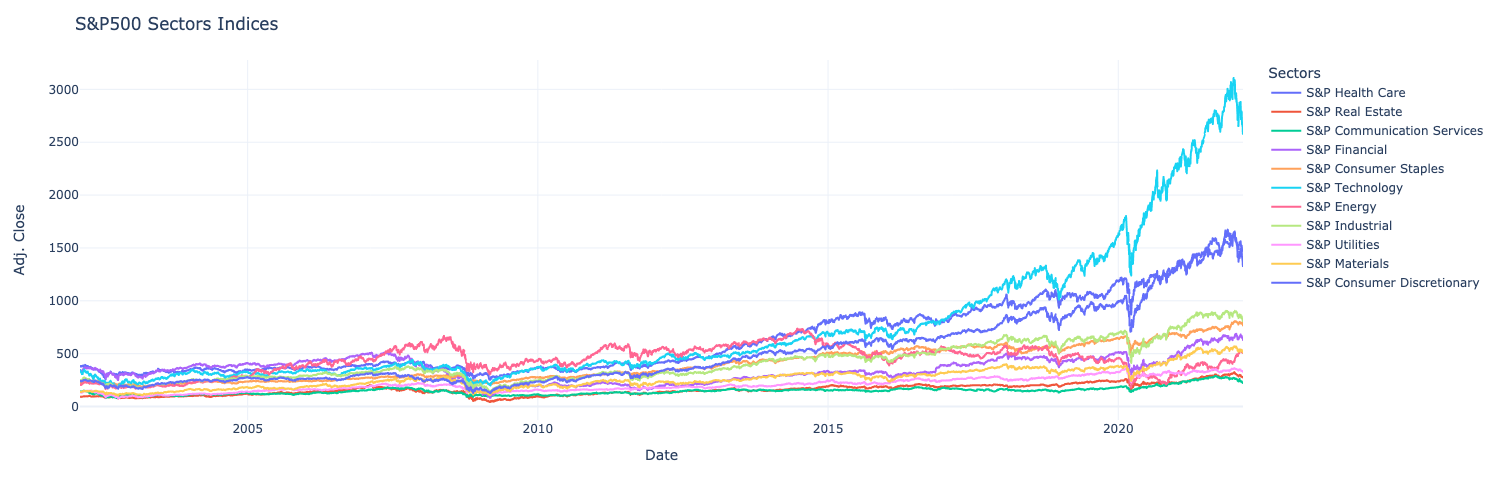

In [3]:
px.line(df).update_layout(
    yaxis_title='Adj. Close', legend_title='Sectors',
    title='S&P500 Sectors Indices'
)

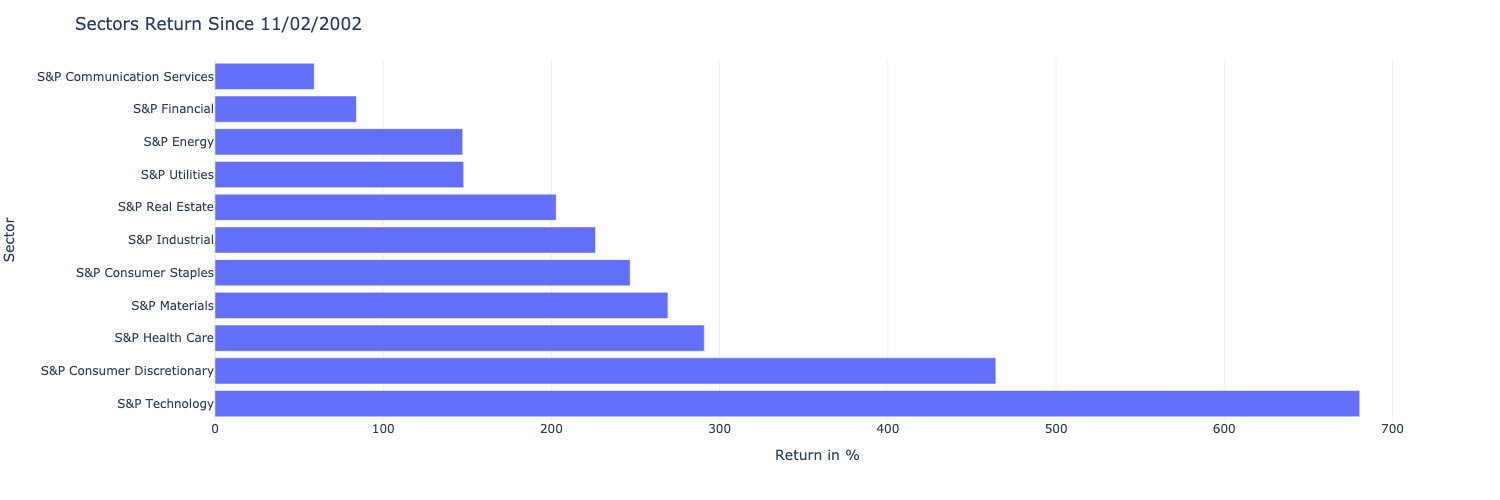

In [4]:
px.bar(100*(df.iloc[-1]-df.iloc[0])/df.iloc[0], orientation='h').update_layout(
    showlegend=False, yaxis={'categoryorder':'total descending'},
    xaxis_title='Return in %', yaxis_title='Sector',
    title='Sectors Return Since 11/02/2002'
)

# Stationarity : Log Daily Losses

In [5]:
# Clearly we don't have stationarity in the Adj. Close time series so we transform them into the log daily losses
# We suppose we have stationarity for now

ll = -100*(np.log(df)-np.log(df.shift(1)))
ll = ll.iloc[1:]
ll = ll.rename_axis('Loss', axis=1)

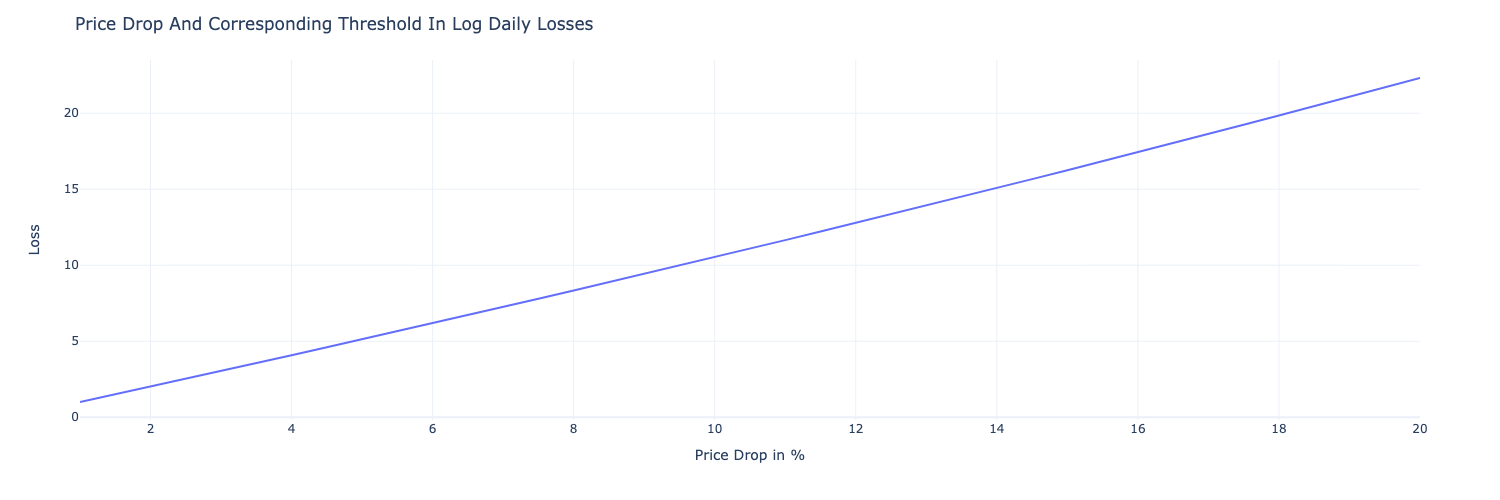

In [6]:
p_drops = np.arange(1,20.5,0.5)
ll_p = [-100*np.log(1-x/100) for x in p_drops]

px.line(x=p_drops, y=ll_p).update_layout(
    xaxis_title='Price Drop in %', yaxis_title='Loss',
    title='Price Drop And Corresponding Threshold In Log Daily Losses'
)

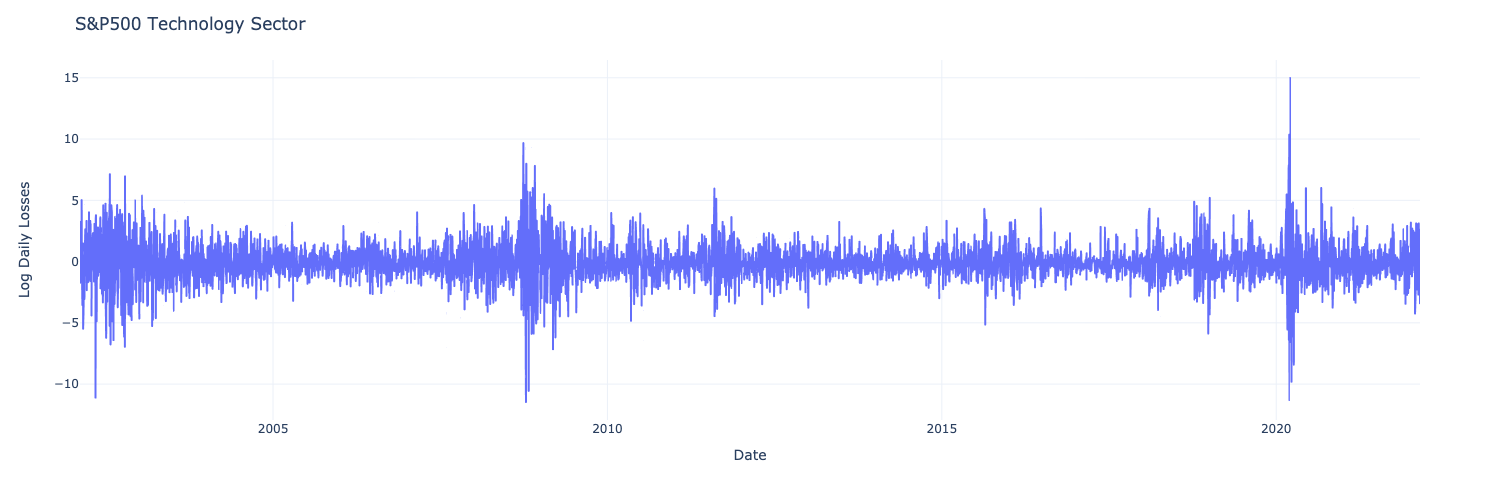

In [7]:
px.line(ll.iloc[:,5]).update_layout(
    showlegend=False, yaxis_title='Log Daily Losses',
    title='S&P500 Technology Sector'
)

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss

import warnings
warnings.filterwarnings('ignore')

for s in ll.columns:
    
    print('Series :',s)
    
    result1 = adfuller(ll[s].values)[1]
    print('Dickey–Fuller p-value: %f' % result1)
    
    result2 = kpss(ll[s].values, regression='c', nlags=5)[1]
    print('KPSS p-value: %f' % result2)
        
    if (result1<0.01) & (result2>0.01):
        print('Series is stationary.')
    else:
        print('Fail to reject the null hypothesis.')
        
    print('')

Series : S&P Health Care
Dickey–Fuller p-value: 0.000000
KPSS p-value: 0.100000
Series is stationary.

Series : S&P Real Estate
Dickey–Fuller p-value: 0.000000
KPSS p-value: 0.100000
Series is stationary.

Series : S&P Communication Services
Dickey–Fuller p-value: 0.000000
KPSS p-value: 0.100000
Series is stationary.

Series : S&P Financial
Dickey–Fuller p-value: 0.000000
KPSS p-value: 0.100000
Series is stationary.

Series : S&P Consumer Staples
Dickey–Fuller p-value: 0.000000
KPSS p-value: 0.100000
Series is stationary.

Series : S&P Technology
Dickey–Fuller p-value: 0.000000
KPSS p-value: 0.091012
Series is stationary.

Series : S&P Energy
Dickey–Fuller p-value: 0.000000
KPSS p-value: 0.100000
Series is stationary.

Series : S&P Industrial
Dickey–Fuller p-value: 0.000000
KPSS p-value: 0.100000
Series is stationary.

Series : S&P Utilities
Dickey–Fuller p-value: 0.000000
KPSS p-value: 0.100000
Series is stationary.

Series : S&P Materials
Dickey–Fuller p-value: 0.000000
KPSS p-value:

# Exploratory Data Analysis
For simplicity, we denote the Log Daily Losses by loss.

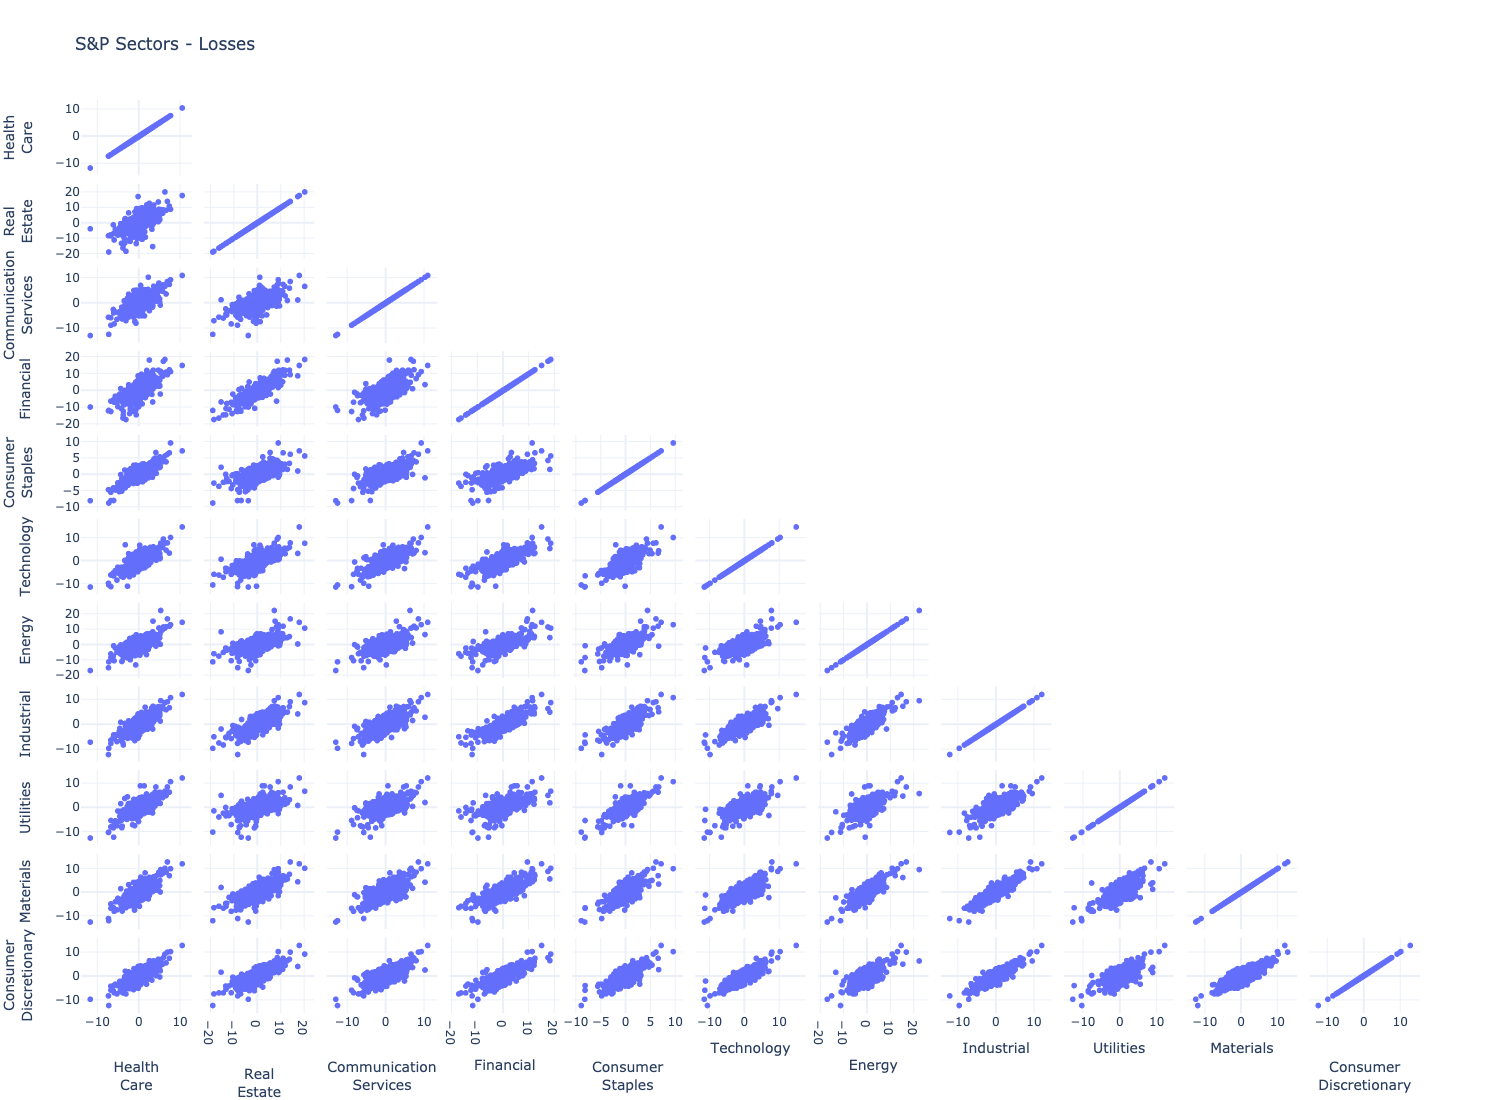

In [9]:
fig = go.Figure(
    data=go.Splom(
        dimensions=[dict(label=s[4:].replace(' ','<br>'), values=ll[s]) for s in ll.columns.values],
        showupperhalf=False
    )
).update_layout(
    title='S&P Sectors - Losses',
    width=1500, height=1100,
)

fig.show()

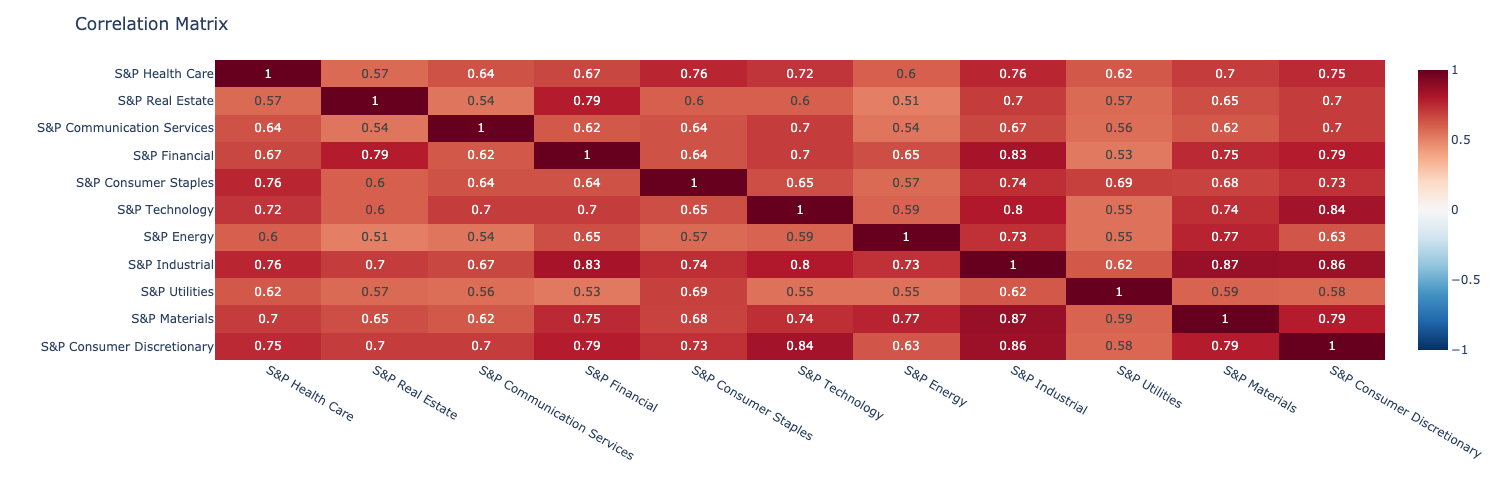

In [10]:
px.imshow(ll.corr().round(2), color_continuous_scale='RdBu_r', range_color=[-1,1], text_auto=True, aspect='auto').update_layout(
    title='Correlation Matrix',
    xaxis_title='', yaxis_title=''
)

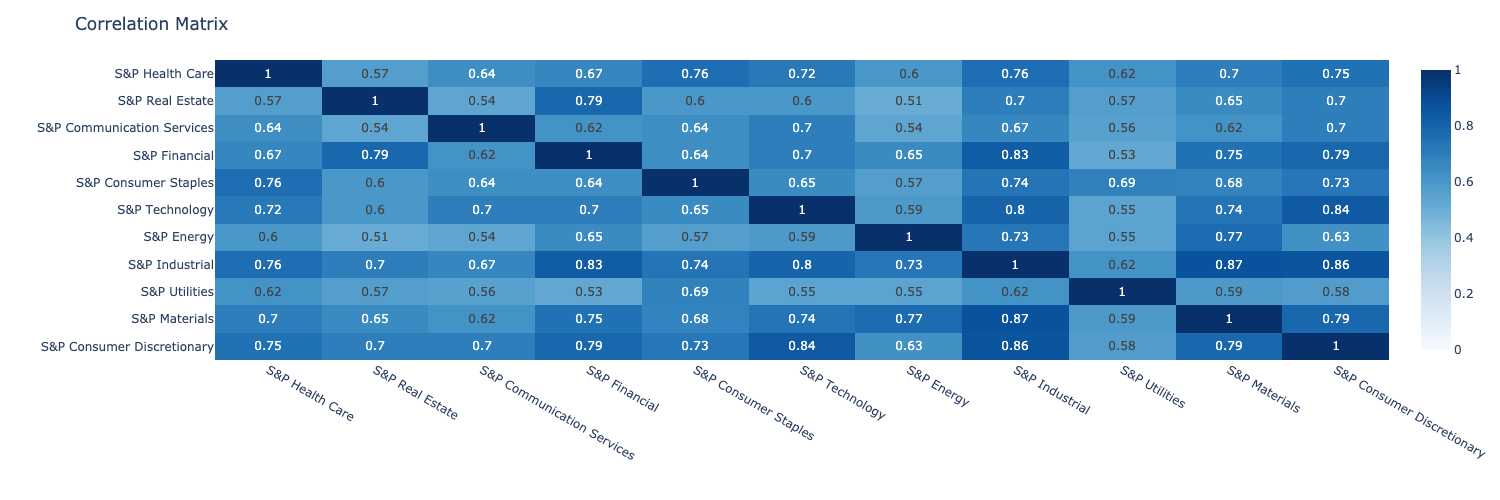

In [11]:
px.imshow(ll.corr().round(2), color_continuous_scale='Blues', range_color=[0,1], text_auto=True, aspect='auto').update_layout(
    title='Correlation Matrix',
    xaxis_title='', yaxis_title=''
)

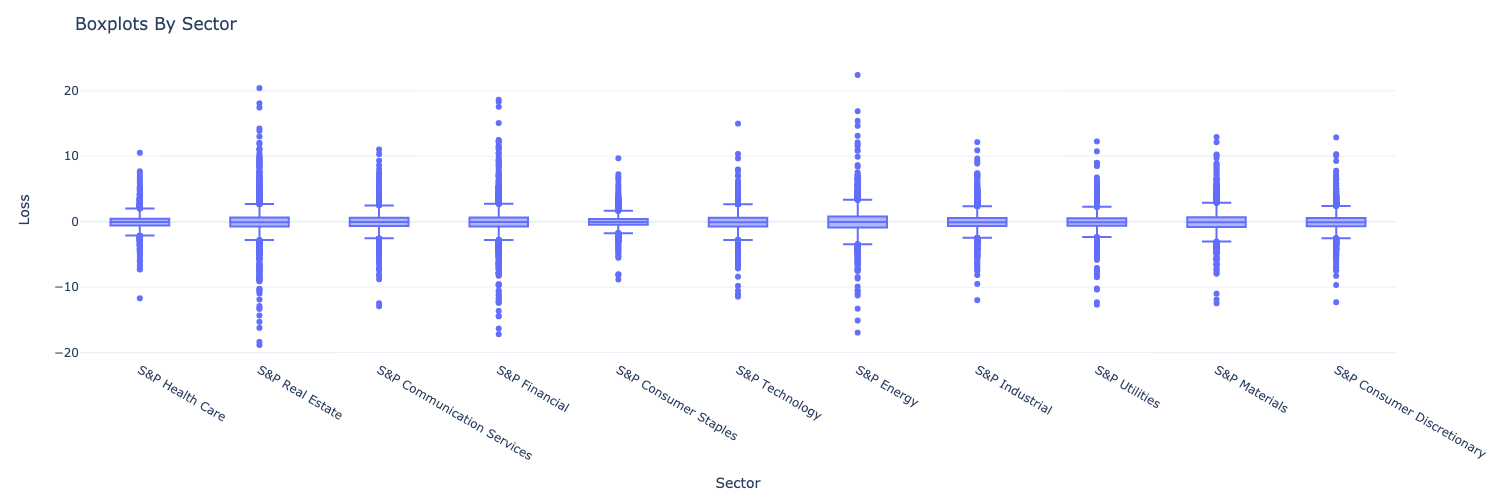

In [12]:
px.box(ll).update_layout(
    xaxis_title='Sector', yaxis_title='Loss',
    title='Boxplots By Sector'
)

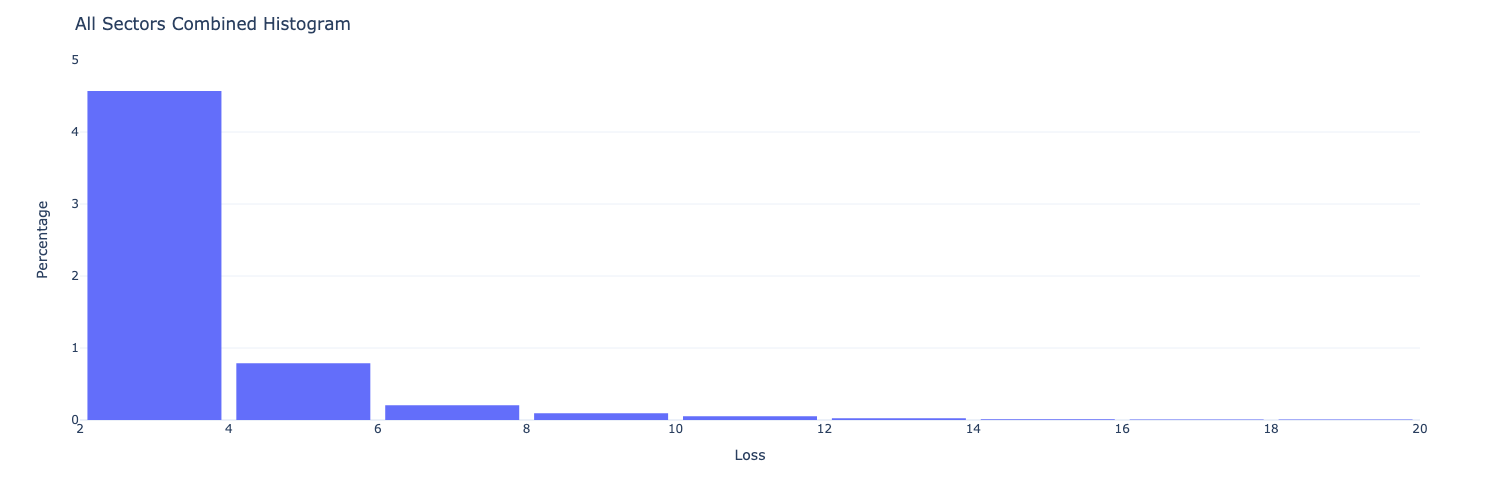

In [13]:
px.histogram(x=ll.values.reshape(-1), histnorm='percent', cumulative=False, nbins=30).update_layout(
    xaxis_title='Loss', yaxis_title='Percentage',
    title='All Sectors Combined Histogram',
    showlegend=False, bargap=0.1
).update_xaxes(range=(2,20)).update_yaxes(range=(0,5))

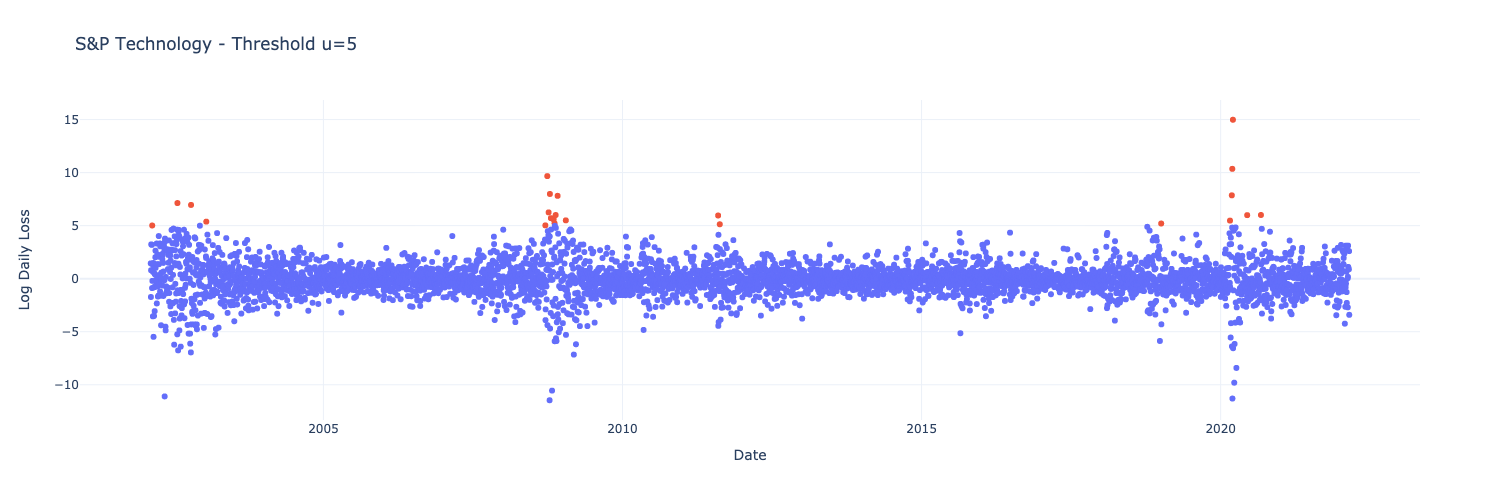

In [20]:
ts = ll.iloc[:,5]
u = 5

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ts.index, y=ts.values, mode='markers', marker_color=['#EF553B' if x>u else '#636EFA' for x in ts.values]
))

fig.update_layout(
    title=ts.name+' - Threshold u='+str(u),
    xaxis_title='Date', yaxis_title='Log Daily Loss',
    height=500, width=1500
)

# Empirical Estimate Of Asymptotic Dependence

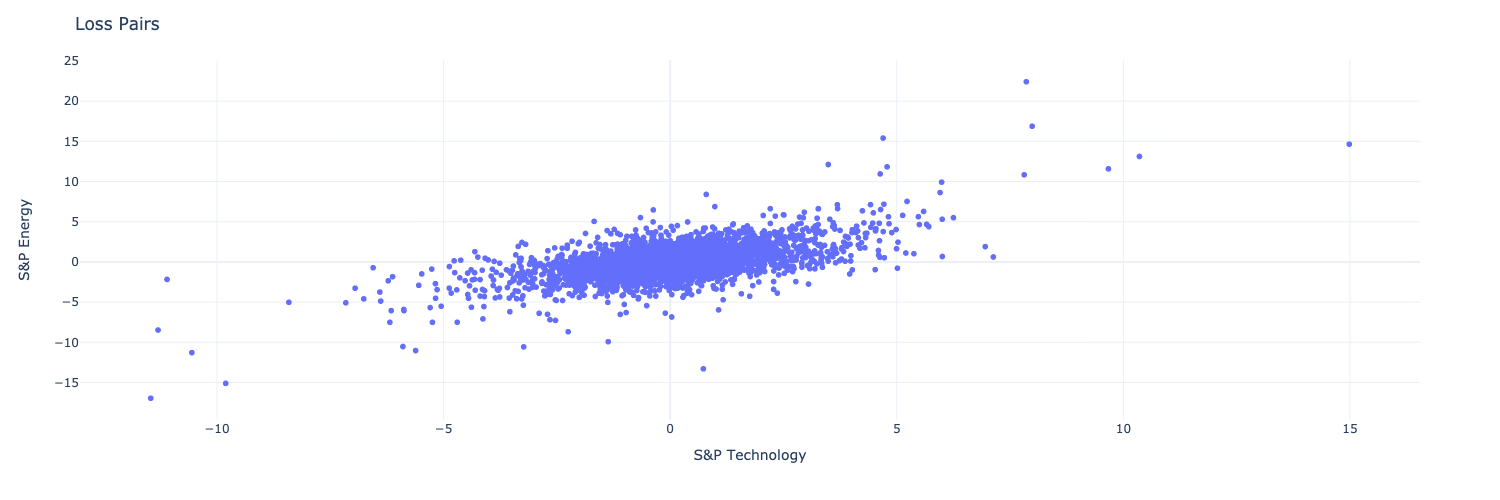

In [14]:
ts1 = ll.iloc[:,5]
ts2 = ll.iloc[:,6]

px.scatter(x=ts1, y=ts2).update_layout(
    title='Loss Pairs',
    xaxis_title=ts1.name, yaxis_title=ts2.name
)

In [15]:
def get_chi(ts1,ts2):
    
    n = len(ts1)
    q_range = np.arange(0.01,1,0.01)

    chi = []
    chib = []

    for q in q_range:

        fu, fd, chiu, chid = 0,0,0,0

        for i in range(n):

            fxi = ((ts1<=ts1[i]).sum()-1)/(n-1)
            fyi = ((ts2<=ts2[i]).sum()-1)/(n-1)

            fu += int((fxi<q) and (fyi<q))
            fd += 1-int((fxi<q) or (fyi<q))

        chiu = 2-np.log(fu/n)/np.log(q)
        chi.append(chiu)

        chid = 2*np.log(1-q)/np.log(fd/n)-1
        chib.append(chid)
        
    return q_range, chi, chib

In [16]:
def plot_chi(ts1,ts2):
    
    q_range, chi, chib = get_chi(ts1,ts2)

    fig = make_subplots(rows=1, cols=2, subplot_titles=['Chi','Chi Bar'])

    fig.add_trace(
        go.Scatter(x=q_range, y=chi),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=q_range, y=chib),
        row=1, col=2
    )

    if 0:
        fig.add_trace(
            go.Scatter(x=q_range, y=chil, line_color='grey', line_dash='dash'),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(x=q_range, y=chih, line_color='grey', line_dash='dash'),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(x=q_range, y=chibl, line_color='grey', line_dash='dash'),
            row=1, col=2
        )

        fig.add_trace(
            go.Scatter(x=q_range, y=chibh, line_color='grey', line_dash='dash'),
            row=1, col=2
        )

    fig.update_xaxes(title_text='q')
    fig.update_yaxes(title_text=r'$\chi(q)$', range=[0,1], row=1, col=1)
    fig.update_yaxes(title_text=r'$\bar{\chi}(q)$', range=[-1,1], row=1, col=2)

    fig.update_layout(
        title_text='Empirical Estimate Of Asymptotic Dependence : '+ts1.name+' / '+ts2.name,
        showlegend=False,
        height=600, width=1200
    )

    return fig

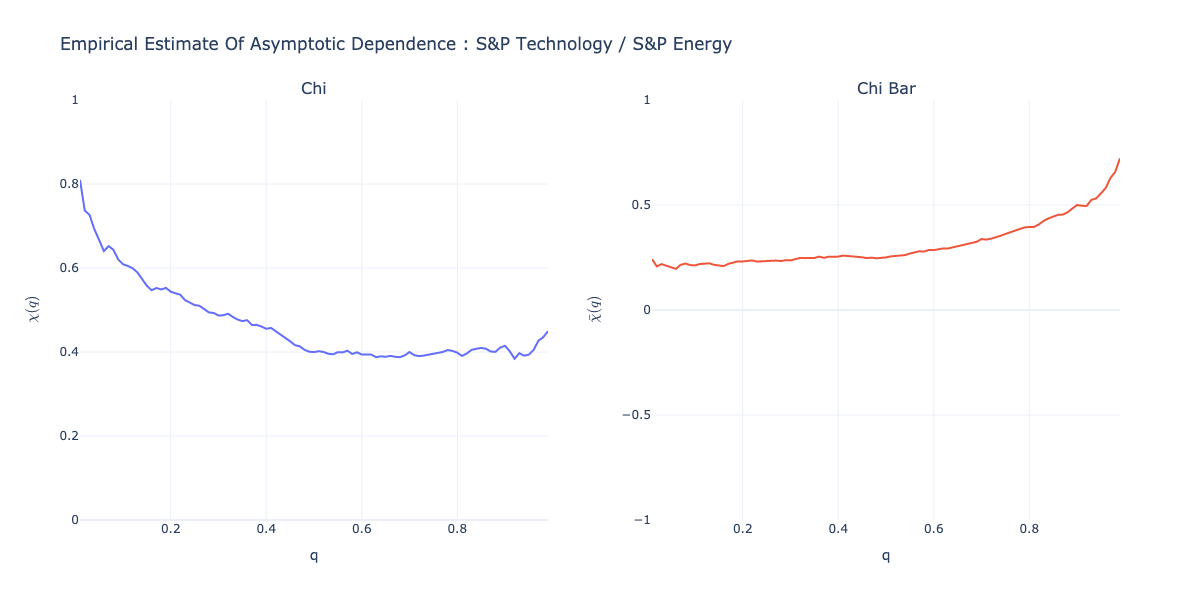

In [17]:
plot_chi(ts1,ts2)

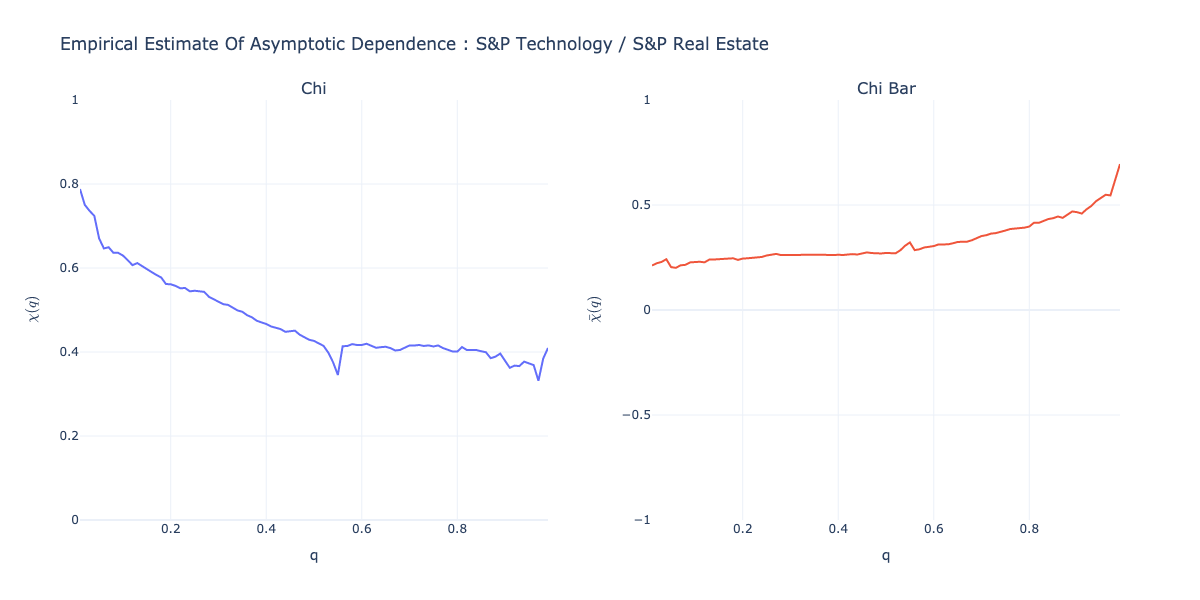

In [18]:
plot_chi(ts1,ll.iloc[:,1])

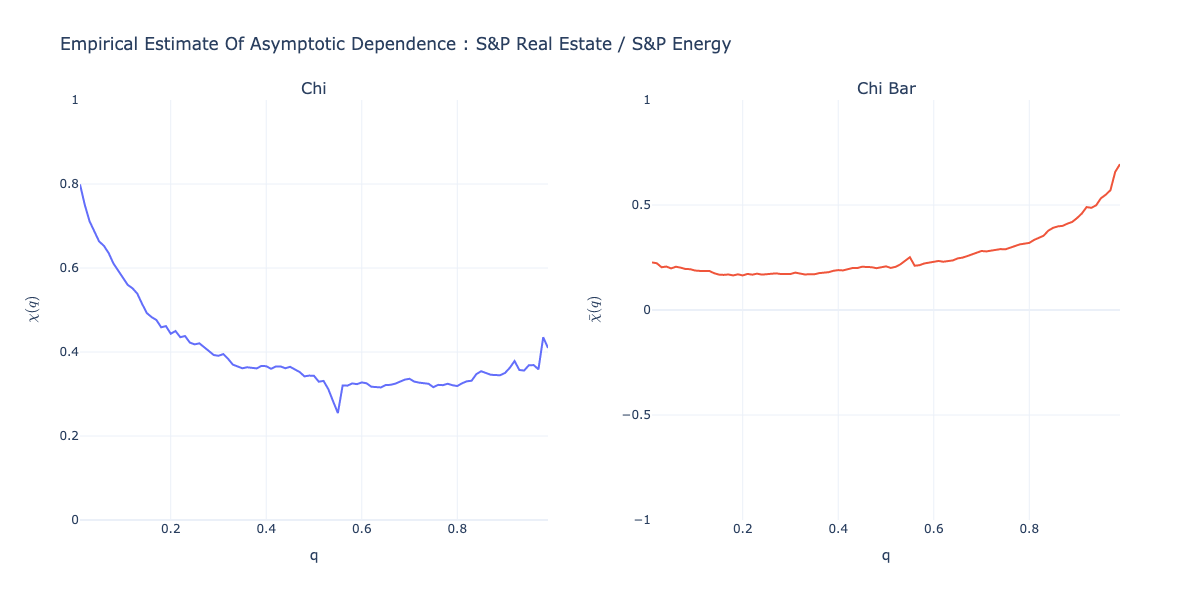

In [19]:
plot_chi(ll.iloc[:,1],ts2)